In [1]:
library(lme4)
library(car)
library(lmerTest)
library(tidyverse)
library(ragg)
library(HLMdiag)
library(VCA)
library(hrbrthemes)
library(ggResidpanel)
library(brms)

Warning message:
“package ‘lme4’ was built under R version 4.0.5”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.0.5”
Warning message:
“package ‘car’ was built under R version 4.0.5”
Loading required package: carData

Warning message:
“package ‘lmerTest’ was built under R version 4.0.5”

Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built un

# Forced-choice survey LMER

In [2]:
df = read_csv("../clean_data/free_labeling_emotion_uw_students_long_format_lmer.csv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




In [3]:
head(df)

participantId,photoId,emotion,ethnicity,sex,age,label,url,sentimentScore,sexC,ageC,ethnicityC
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,Q2.1_1,angry,bipoc,female,adult,anger,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bJXdODAZHOaG0rI,-0.5106,-0.5,0.5,-0.5
0,Q102.1_1,bored,bipoc,male,child,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bw2zfW24xOcYU9o,-0.2732,0.5,-0.5,-0.5
0,Q103.1_1,bored,white,female,adult,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bqKH78xvssoHVoG,-0.2732,-0.5,0.5,0.5
0,Q194.1_1,funny,white,male,adult,uncertain,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_8oGUDKsFJy6Upeu,0.4404,0.5,0.5,0.5
0,Q104.1_1,scared,white,female,child,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_7WGuIqyEG3TilMi,-0.4404,-0.5,-0.5,0.5
0,Q101.1_1,sad,bipoc,male,adult,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_3gSfRO9Zt2G8NP8,-0.4767,0.5,0.5,-0.5


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



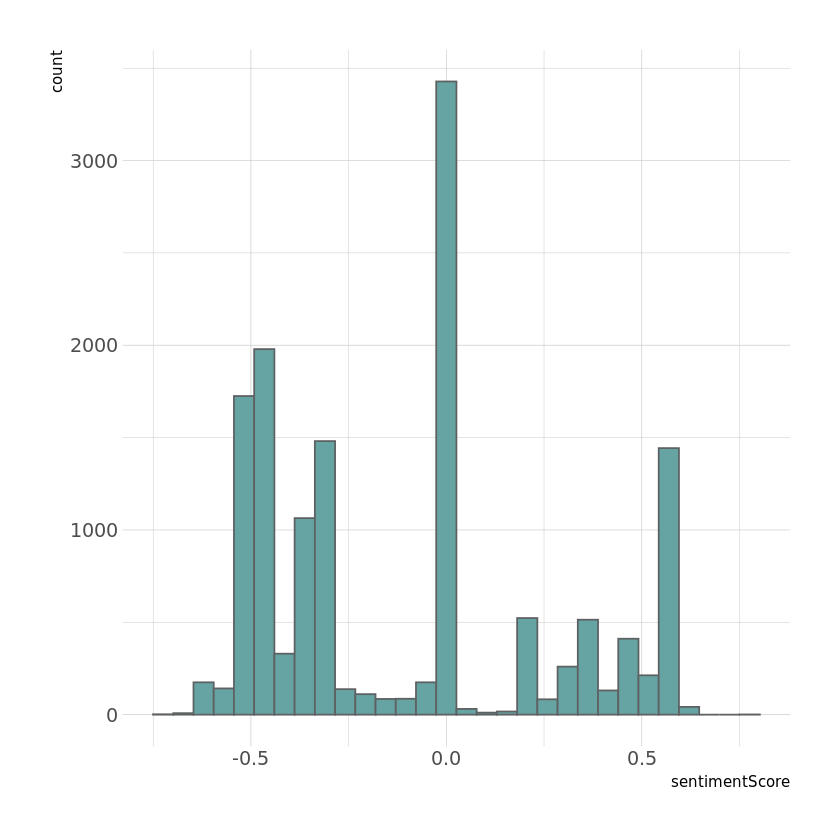

In [4]:
df %>%  ggplot(aes(x=sentimentScore)) +
    geom_histogram(color="#5e6162", fill="#66a3a3") +
    theme_ipsum()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



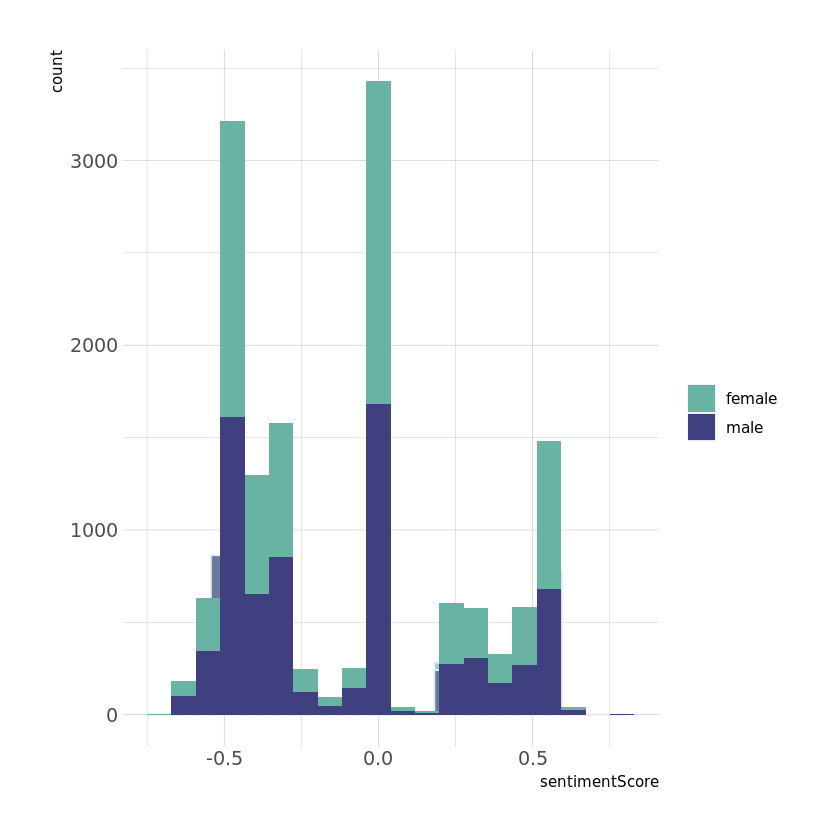

In [5]:
by.sex <- df %>%
  ggplot( aes(x=sentimentScore, fill=sex)) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    theme_ipsum() +
    stat_bin(bins=20) +
    labs(fill="")
by.sex

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



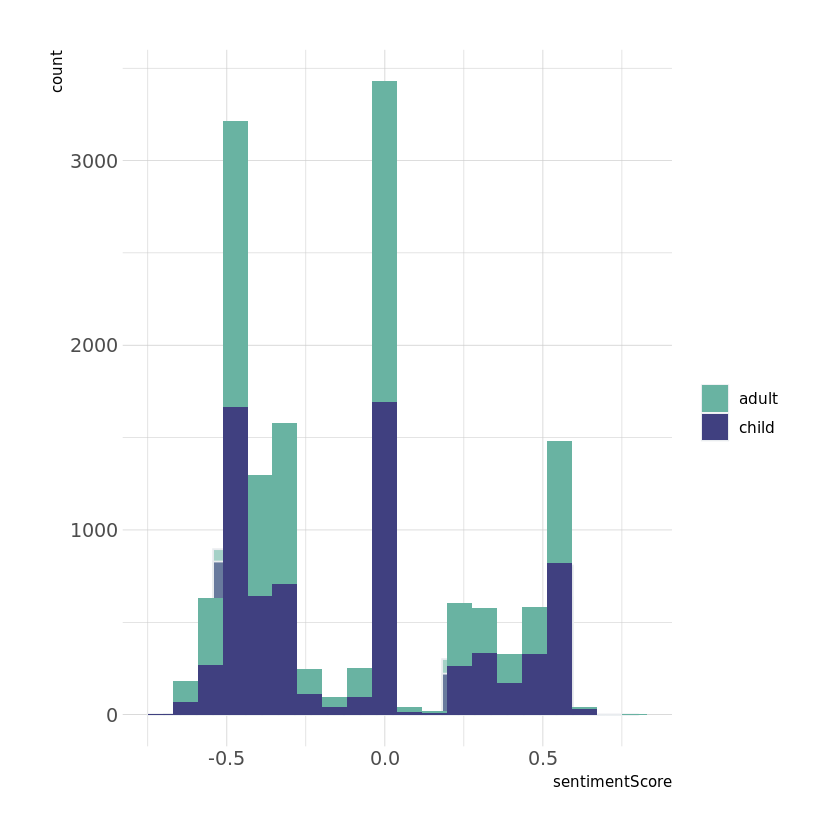

In [6]:
by.age <- df %>%
  ggplot( aes(x=sentimentScore, fill=age)) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    theme_ipsum() +
    stat_bin(bins=20) +
    labs(fill="")
by.age

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



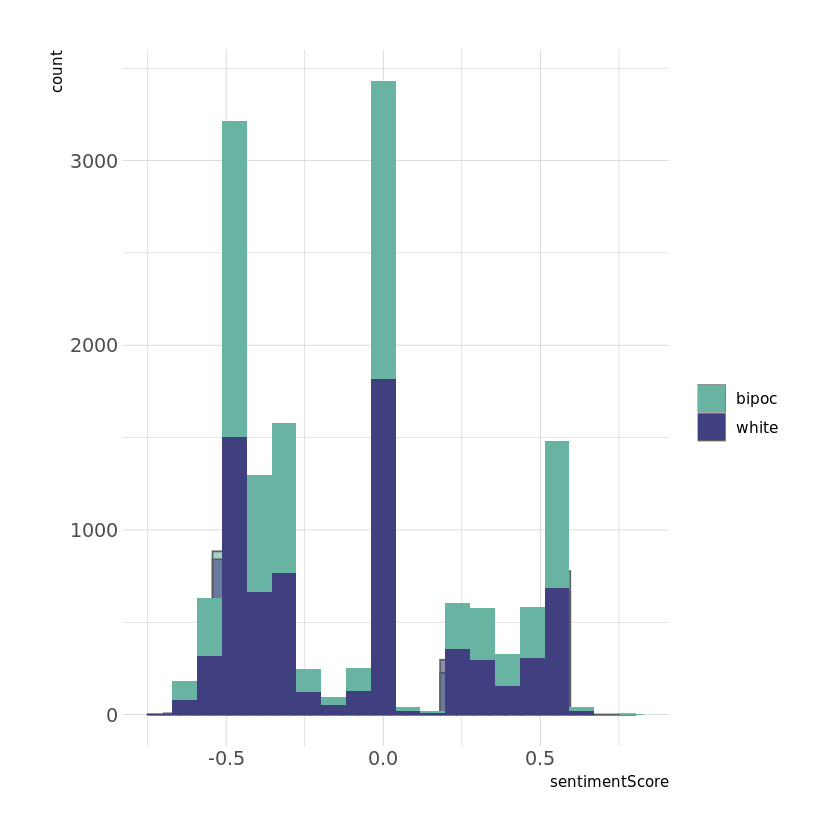

In [7]:
by.ethnicity <- df %>%
  ggplot( aes(x=sentimentScore, fill=ethnicity)) +
    geom_histogram( color="#5e6162", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    theme_ipsum() +
    stat_bin(bins=20) +
    labs(fill="")
by.ethnicity

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



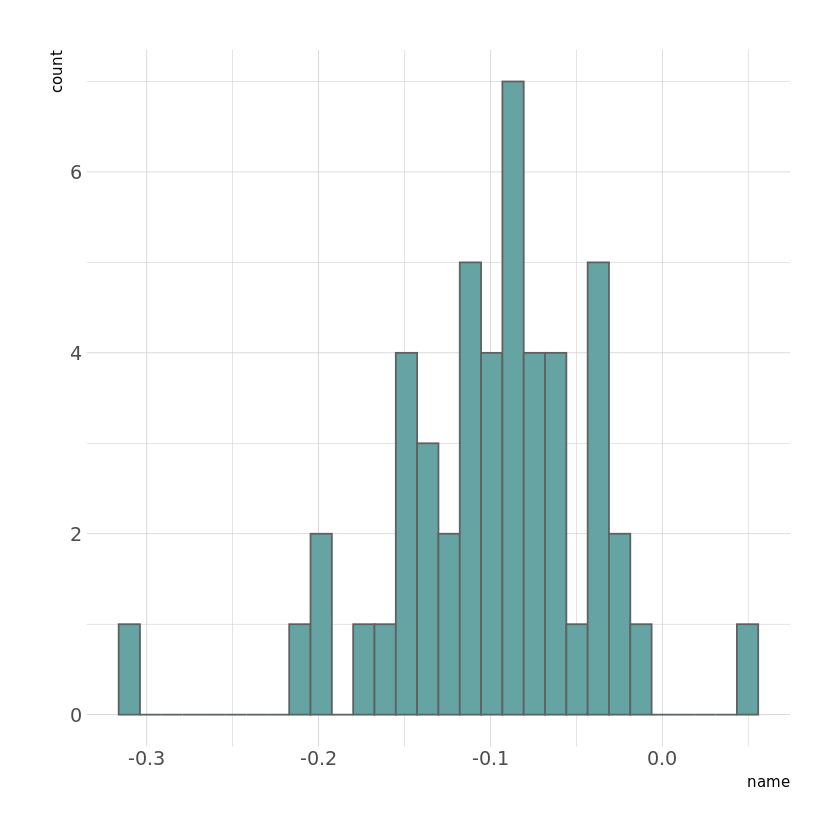

In [8]:
df %>%
  group_by(participantId) %>%
  summarise_at(vars(sentimentScore), list(name = mean)) %>% 
  ggplot(aes(x=name)) +
    geom_histogram(color="#5e6162", fill="#66a3a3") +
    theme_ipsum()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



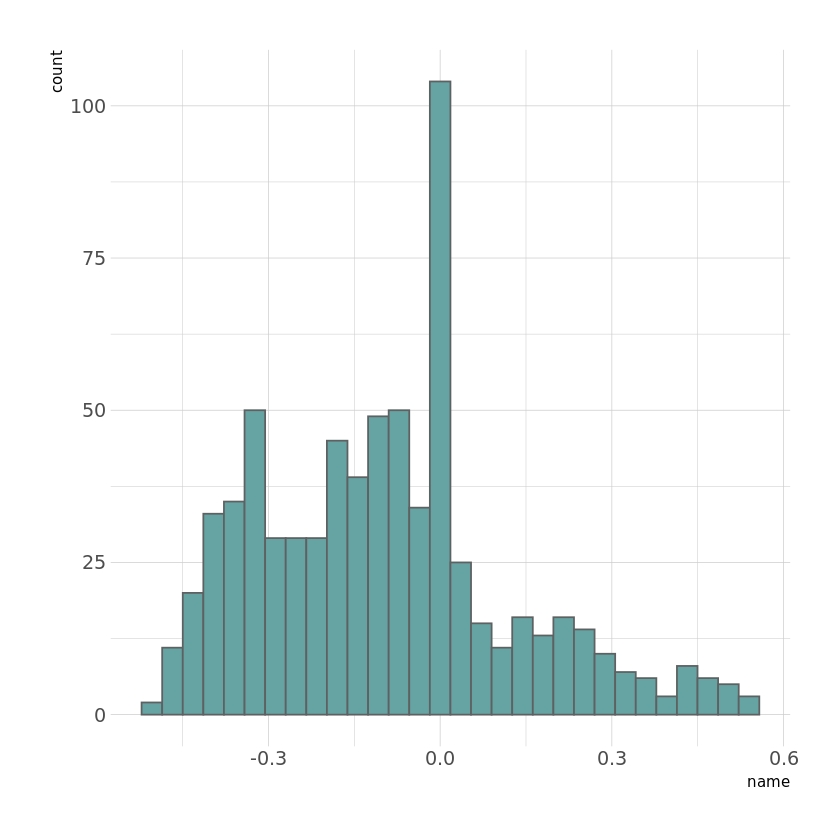

In [9]:
df %>%
  group_by(photoId) %>%
  summarise_at(vars(sentimentScore), list(name = mean)) %>% 
  ggplot(aes(x=name)) +
    geom_histogram(color="#5e6162", fill="#66a3a3") +
    theme_ipsum()

## Maximal random effects structure

In [10]:
# # with derivatives check
# control.check=lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE, optCtrl=list(maxfun=2e6), check.nobs.vs.nRE = "ignore")

# m1<-lmer(
#     sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
#     data = df,
#     control=control.check)
# summary(m1)

In [11]:
# # without derivatives check
# control=lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE, optCtrl=list(maxfun=2e6), check.nobs.vs.nRE = "ignore")

# m1<-lmer(
#     sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
#     data = df,
#     control=control)
# summary(m1)

In [12]:
# MAXIMAL MODEL doesn't converge at all / tried multiple optimizers 

## Simplified random effects structure

In [13]:
#  with derivatives check
# control.check=lmerControl(optimizer ="Nelder_Mead", optCtrl=list(maxfun=2e6), check.nobs.vs.nRE = "ignore")


# control=lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE,optCtrl=list(maxfun=2e6),check.nobs.vs.nRE = "ignore")
# m2<-lmer(
#     sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), 
#     data = df,
#     control=control.check)
# summary(m2)

In [14]:
## doesn't converge

In [15]:
## without derivatives check
control=lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE, optCtrl=list(maxfun=2e6), check.nobs.vs.nRE = "ignore")


control=lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE,optCtrl=list(maxfun=2e6),check.nobs.vs.nRE = "ignore")
m2<-lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), 
    data = df,
    control=control)
summary(m2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId)
   Data: df
Control: control

REML criterion at convergence: 12007.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.93815 -0.88268 -0.02124  0.65389  2.59100 

Random effects:
 Groups        Name            Variance  Std.Dev. Corr             
 participantId (Intercept)     3.248e-03 0.056991                  
               sexC            4.001e-06 0.002000 -1.00            
               ethnicityC      3.997e-04 0.019992  0.14 -0.09      
               sexC:ethnicityC 3.379e-05 0.005813 -0.82  0.80 -0.59
 Residual                      1.320e-01 0.363261                  
Number of obs: 14609, groups:  participantId, 49

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     -9.839e-02  8.798e-03  4.963e+01 -11.182 3.63e-15 ***
sexC   

In [16]:
# Anova(m2,type=3,t="F")  
# ------------------- 
# it won't coverge

In [17]:
## Type III anova table with p-values for F-tests based on Satterthwaite's
## method:
(aov <- anova(m2))

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sexC,1.9983813,1.9983813,1,5931.95285,15.144026,1.007044e-04
ethnicityC,0.3668165,0.3668165,1,44.10739,2.779789,1.025469e-01
sexC:ethnicityC,3.6743672,3.6743672,1,2693.10834,27.844892,1.418980e-07


In [18]:
format(1.007044e-04, scientific = F)

[1] "0.0001007044"

In [19]:
format(1.025469e-01, scientific = F)

[1] "0.1025469"

In [20]:
format(1.418980e-07, scientific = F)

[1] "0.000000141898"

## Model interpretation

In [21]:
### UPDATE ###



# sex-photo effect:
# The effect of sex-photo on sentiment-score was not significant, b = -0.01602, F(1,51) = 3.7, p = 0.054
# Averaging across POC and Caucasian photo-faces, and controlling for ethnicity and the ethnicity-photo by sex-photo interaction,
# sentiment-scores were -0.016 more negative in response to male faces than female faces. 

In [22]:
### UPDATE ###


# ethnicity-photo effect:
# The effect of ethnicity-photo on sentiment-scores was significant, b =  0.028, F(1,51) = 11.9, p < .001.
# For sake of completeness:
# Averaging across female and male photos, and controlling for sex-photo and the sex-photo by ethnicity-photo interaction,
# sentiment-scores were 0.028 more positive in response to caucasian-photos than poc-photos

In [23]:
### UPDATE ###


# Face by odor interaction:
# The face by odor interaction was significant, b = 0.04, F(1,51) = 6.03, p = 0.014.
# For sake of completeness:
# Controlling for lower-order effects, the difference in sentiment-scorees between the two sex-photo conditions 
# was 0.04 points greater in the caucasian-photos than in the poc-photos

## Indiviual subject data points

In [24]:
p = ggplot(df,aes(sex,sentimentScore,color=ethnicity,group=ethnicity))+
    geom_point()+
    geom_smooth(method="lm",se=F)+
    facet_wrap(~participantId)+
    theme_bw()

# pngfile <- fs::path(knitr::fig_path(),  "resolution.png")
# agg_png(pngfile, width = 7087, height = 4252, units = "px", res = 900)
# plot(p)
# invisible(dev.off())
# knitr::include_graphics(pngfile)

In [25]:
pngfile <- fs::path(knitr::fig_path(),  "scaling.png")
agg_png(pngfile, width = 60, height = 60, units = "cm", res = 300, scaling = 2.5)
plot(p)
invisible(dev.off())
knitr::include_graphics(pngfile)

`geom_smooth()` using formula 'y ~ x'



[1] "figure/-1/scaling.png"
attr(,"class")
[1] "knit_image_paths" "knit_asis"       

![image](figure/-1/scaling.png)

## Testing model assumptions & influence/leverage

- **Linearity**: Do not need to check, because my covariates are categorical.

- **Homogeneity of variance**: Need to Check by plotting residuals vs predicted values.

This one is fine

- **Normality of error term**: need to check by histogram, QQplot of residuals, even Kolmogorov-Smirnov test.

This one is not fine (not normal error)

- **Influence**: no problems here

- **Leverage**: no problems here

https://stats.stackexchange.com/questions/376273/assumptions-for-lmer-models

### Homogeneity of Variance

In [26]:
# ANOVA of the between subjects residuals.
# the assumption is that the variance is not going to differ, we would hope to see 
# NO STATISTICAL DIFFERENCES in the following procedure (i.e. p>0.05)

In [27]:
df$Model.F.Res<- residuals(m2) #extracts the residuals and places them in a new column in our original data table
df$Abs.Model.F.Res <-abs(df$Model.F.Res) #creates a new column with the absolute value of the residuals
df$Model.F.Res2 <- df$Abs.Model.F.Res^2 #squares the absolute values of the residuals to provide the more robust estimate
Levene.Model.F <- lm(Model.F.Res2 ~ participantId, data=df) #ANOVA of the squared residuals
anova(Levene.Model.F) #displays the results

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
participantId,1,0.4849475,0.48494748,25.51597,4.440288e-07
Residuals,14607,277.6154913,0.01900565,NA,NA


In [28]:
format(4.440288e-07, scientific = F)

[1] "0.0000004440288"

In [29]:
# Since the p value < 0.05, we can say that the variance of the residuals is equal and 
# therefore the assumption of **homoscedasticity** NOT is met 

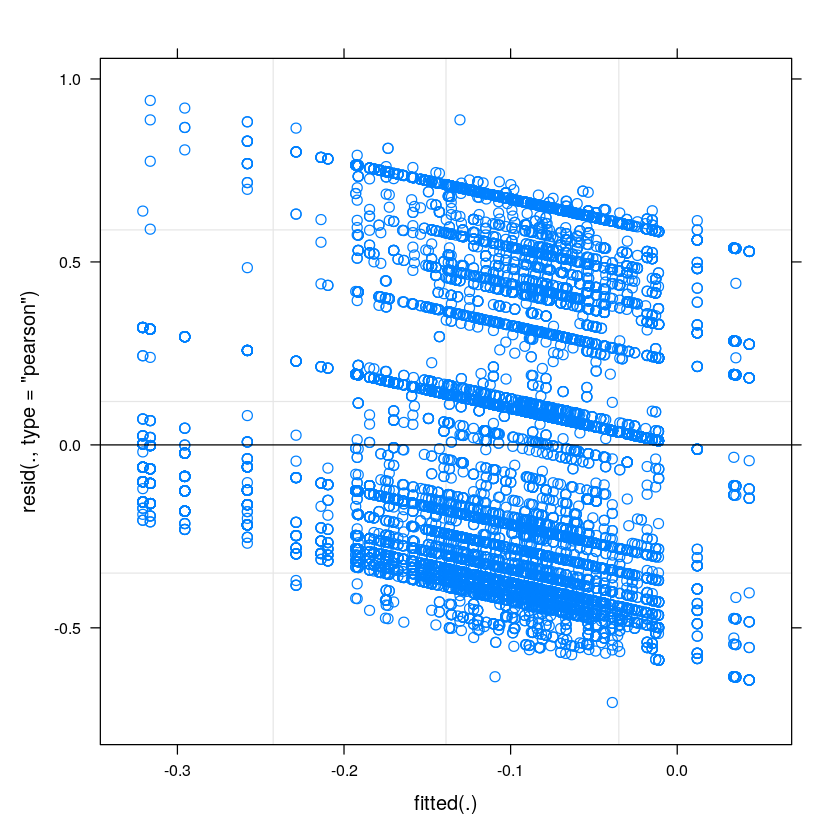

In [30]:
Plot.Model.F <- plot(m2) #creates a fitted vs residual plot
Plot.Model.F

In [31]:
## This looks very unsystematic

Another approach...

In [32]:
resid1 <- hlm_resid(m2, level = 1, standardize = TRUE)

**Level 1 residuals**: observation level  

`geom_smooth()` using formula 'y ~ x'



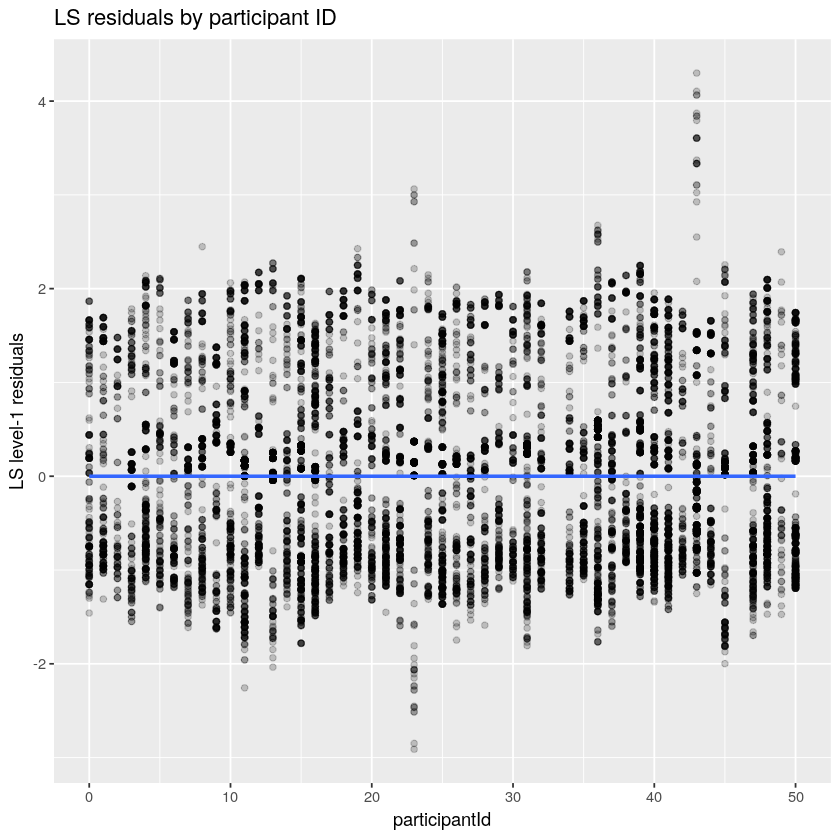

In [33]:
ggplot(data = resid1, aes(x = participantId, y = .std.ls.resid)) + 
  geom_point(alpha = 0.2) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "LS level-1 residuals", 
       title = "LS residuals by participant ID")

In [34]:
## There are quite a couple of large residuals 

**Level 2**: grouped level residuals (by participant)

In [35]:
resid2 = hlm_resid(m2, level = "participantId", standardize = TRUE, include.ls = FALSE)

`geom_smooth()` using formula 'y ~ x'



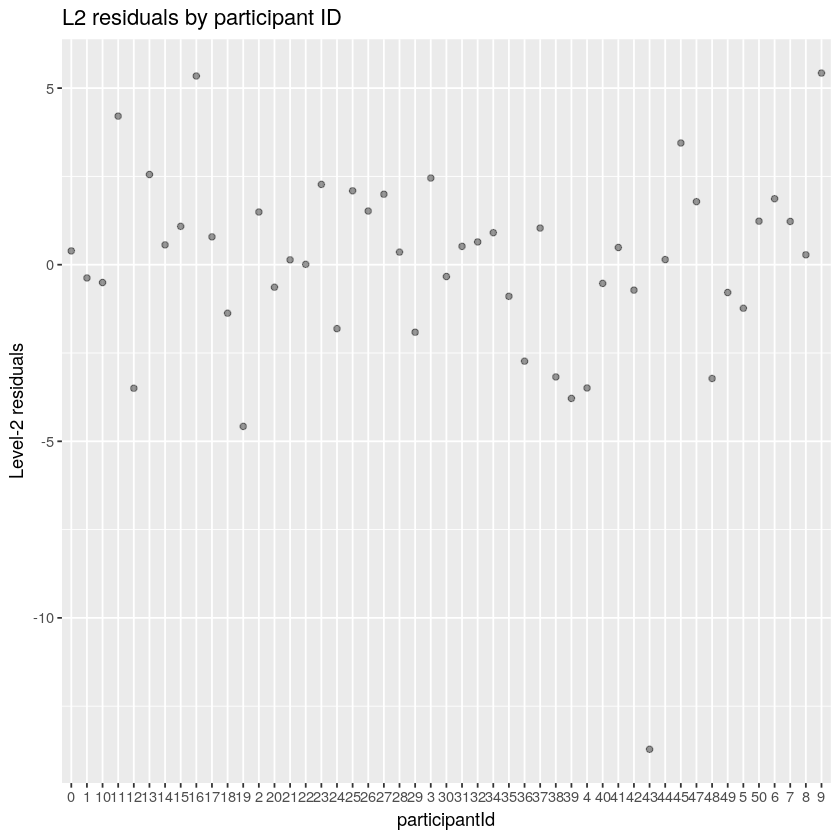

In [36]:
ggplot(data = resid2, aes(x = participantId, y = .std.ranef.intercept)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

In [37]:
# 43, 9, 16

`geom_smooth()` using formula 'y ~ x'



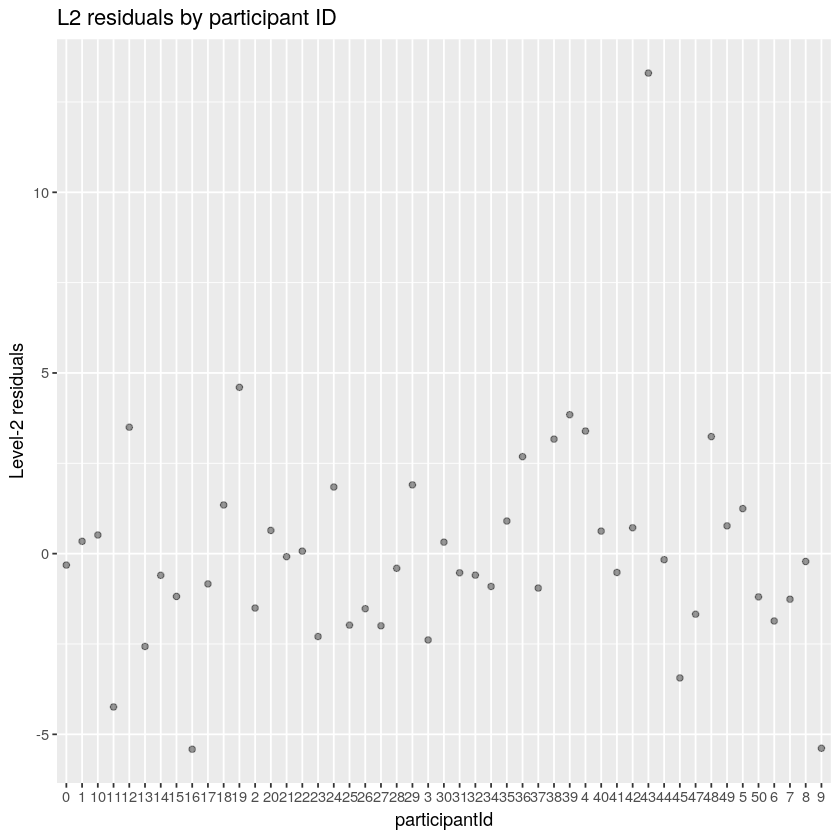

In [38]:
ggplot(data = resid2, aes(x = participantId, y = .std.ranef.sex_c)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

In [39]:
# 9, 16

`geom_smooth()` using formula 'y ~ x'



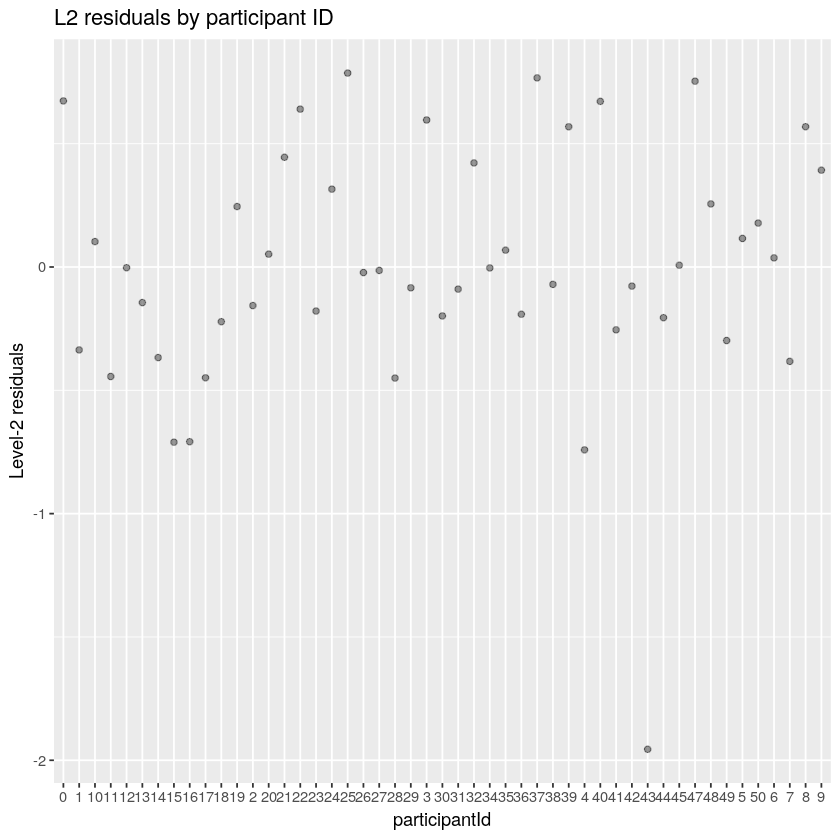

In [174]:
    ggplot(data = resid2, aes(x = participantId, y = .std.ranef.ethnicity_c)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

In [41]:
# 43

In [176]:
resid2

participantId,.std.ranef.intercept,.std.ranef.sex_c,.std.ranef.ethnicity_c,.std.ranef.sex_c_ethnicity_c
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.39030390,-0.31651662,0.673360273,-0.66845733
1,-0.37530684,0.34068904,-0.336185998,0.42691398
2,1.49170803,-1.50590500,-0.156379090,-0.76857060
3,2.45325703,-2.38824833,0.596062759,-1.64912109
4,-3.49075649,3.39265400,-0.741520581,2.03003288
5,-1.23334553,1.24667970,0.115831366,0.54766150
6,1.86787443,-1.86320592,0.037152420,-0.92605232
7,1.22401113,-1.26275532,-0.382599661,-0.34377574
8,0.28091712,-0.21687749,0.568703995,-0.54369666


`geom_smooth()` using formula 'y ~ x'



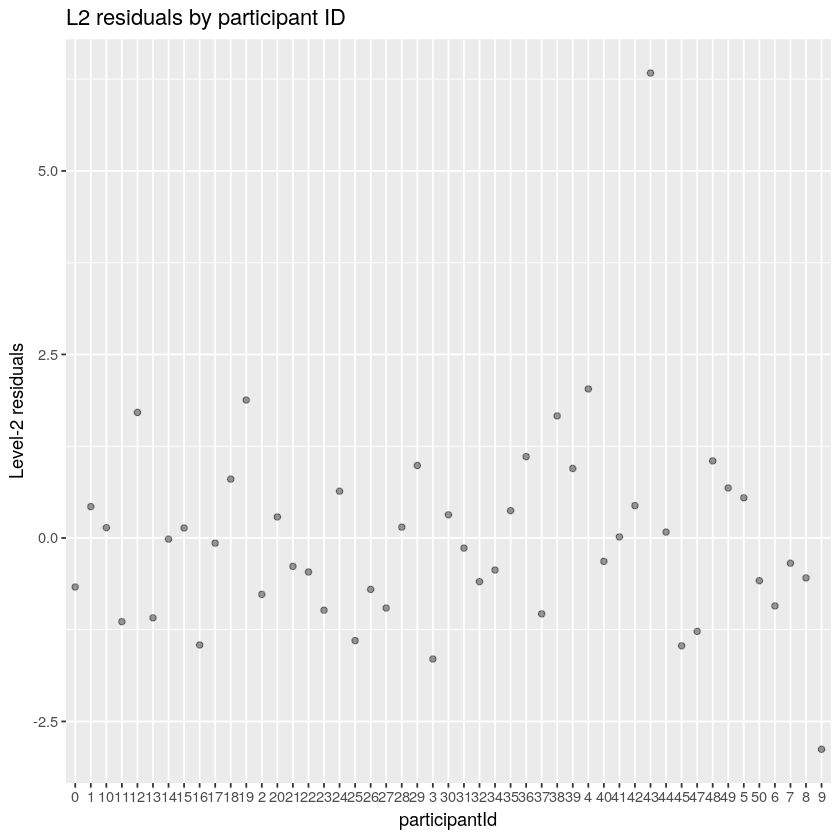

In [177]:
ggplot(data = resid2, aes(x = participantId, y = .std.ranef.sex_c_ethnicity_c)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

In [43]:
# 43, 9

### Normality of the error term (the residuals of the model are normally distributed)

In [44]:
require("lattice")

Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.0.3”


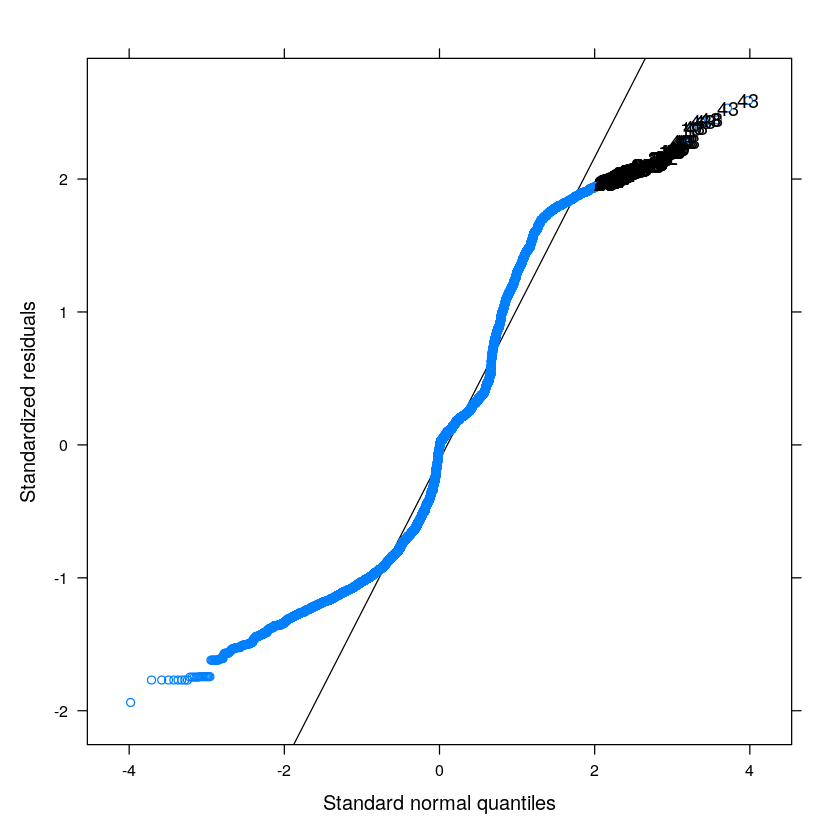

In [45]:
qqmath(m2, id=0.05) #id: identifies values that may be exerting undue influence on the model (i.e. outliers)

In [46]:
# looks not normal...
# https://ademos.people.uic.edu/Chapter18.html

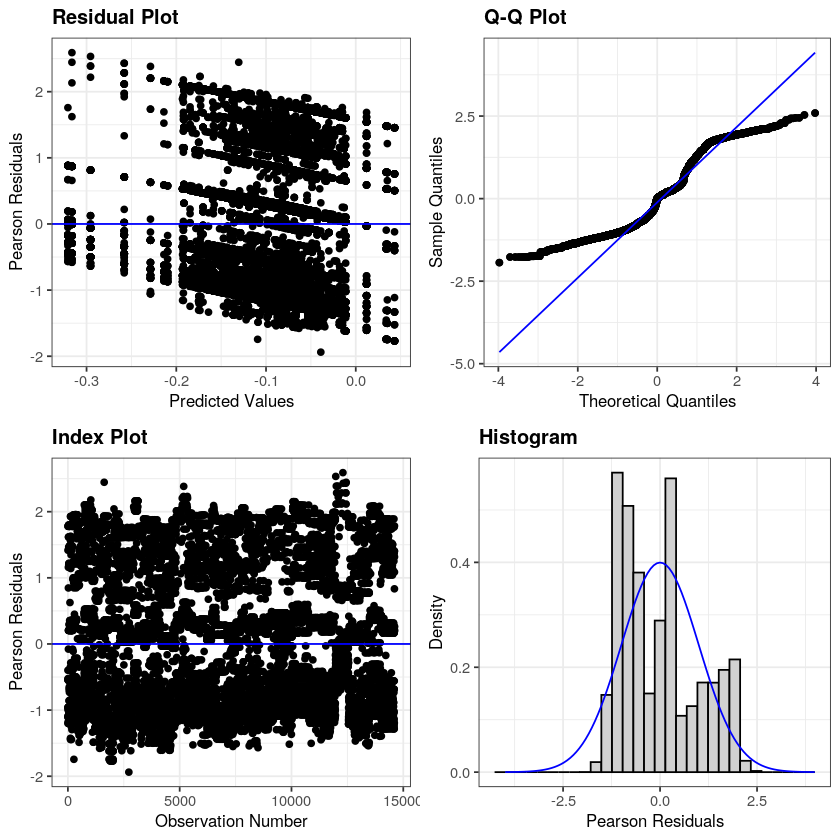

In [47]:
resid_panel(m2)

## Influence

### Influencial datapoints

In [50]:
infl <- hlm_influence(m2, level = 1)

In [91]:
# IQR = as.numeric(format(IQR(infl$cooksd)*3, scientific = F))
CutOff = 4/nrow(infl)
print(CutOff)

[1] 0.0002738038


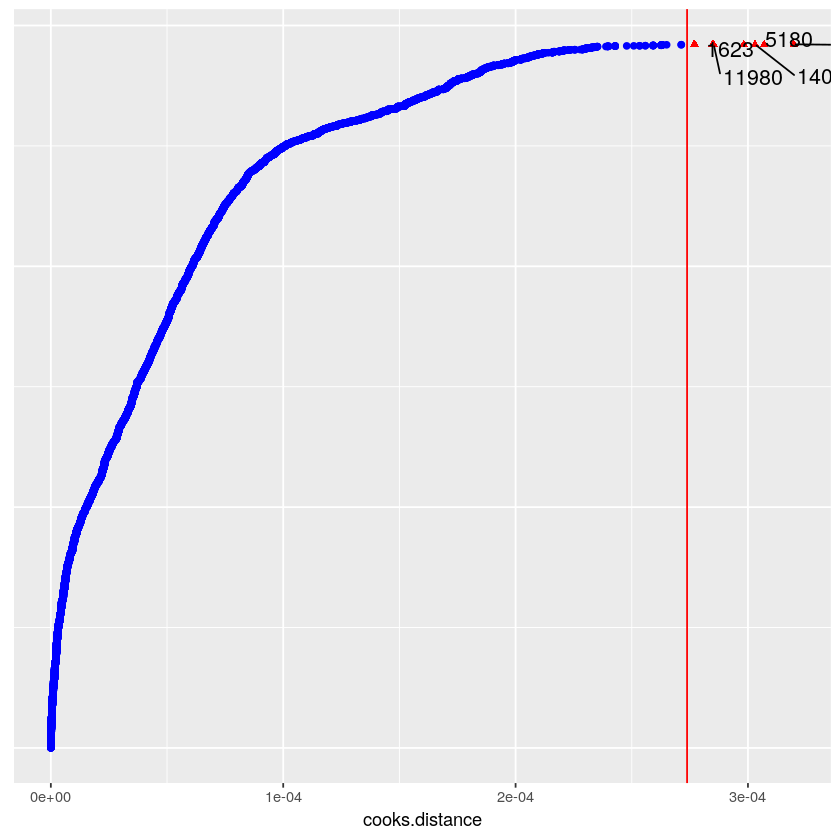

In [90]:
# dotplot_diag(infl$cooksd, name = "cooks.distance", cutoff = "internal")
dotplot_diag(infl$cooksd, name = "cooks.distance", cutoff = CutOff)

In [89]:
# filter(infl, cookd > IQR)

high_cooksd = infl[infl$cooksd > CutOff, ] %>%
  arrange(desc(cooksd))

head(high_cooksd, n=10)

id,sentimentScore,sexC,ethnicityC,participantId,cooksd,mdffits,covtrace,covratio,leverage.overall
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12300,0.6249,0.5,-0.5,43,0.0003196962,0.0003196354,0.0001900629,1.000190,0.002217351
5180,0.6369,0.5,-0.5,19,0.0003069931,0.0003069270,0.0002153878,1.000215,0.003883811
14007,0.5574,-0.5,0.5,49,0.0003030624,0.0003029610,0.0003345076,1.000335,0.012536712
1623,0.7579,0.5,-0.5,8,0.0002982051,0.0002981459,0.0001986486,1.000199,0.004139206
11980,0.6249,0.5,0.5,43,0.0002852741,0.0002852235,0.0001773392,1.000177,0.002132860
12446,0.5719,0.5,-0.5,43,0.0002847054,0.0002846513,0.0001900629,1.000190,0.002217351
14001,0.5574,0.5,0.5,49,0.0002771451,0.0002770574,0.0003164069,1.000316,0.010739259
13997,0.5719,-0.5,-0.5,49,0.0002767809,0.0002766928,0.0003183317,1.000318,0.010616262


In [94]:
# high influence data points
high_cooksd$id

[1] 12300  5180 14007  1623 11980 12446 14001 13997

### Influential individuals

In [48]:
infl.classes <- hlm_influence(m2, level = "participantId")

In [98]:
CutOffGroup = 4/49
CutOffGroup

[1] 0.08163265

Warning message:
“Removed 4 rows containing missing values (geom_text_repel).”


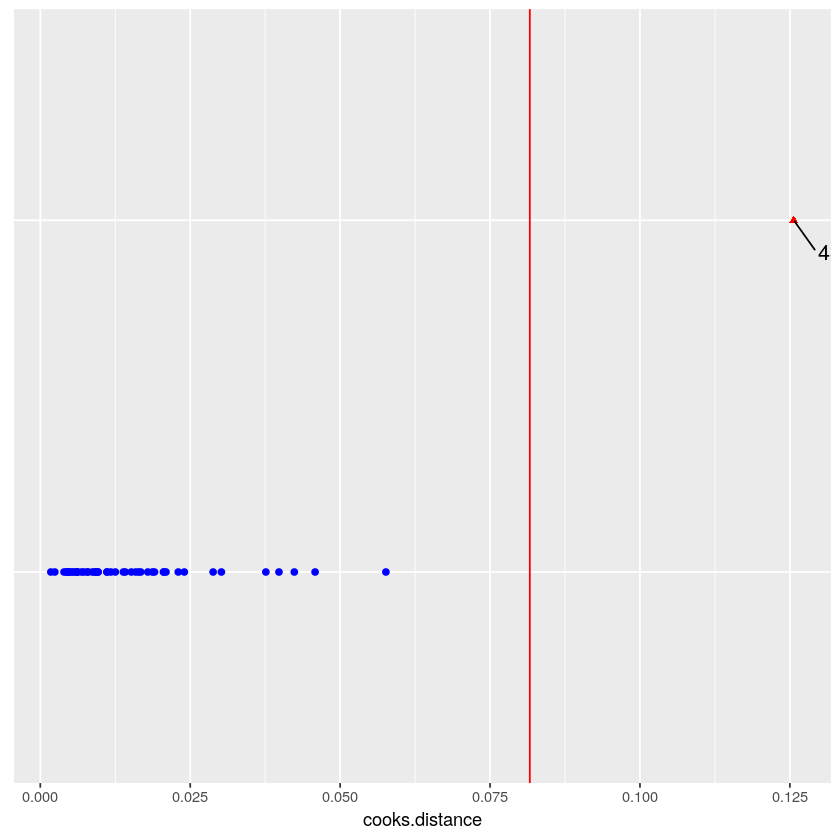

In [100]:
# dotplot_diag(infl.classes$cooksd, name = "cooks.distance", cutoff = "internal", modify = "dotplot")
dotplot_diag(infl.classes$cooksd, name = "cooks.distance", cutoff = CutOffGroup, modify = "dotplot")

In [128]:
high_cooksd_participants = infl.classes[infl.classes$cooksd > CutOffGroup, ] %>%
  arrange(desc(cooksd))

high_cooksd_participants

participantId,cooksd,mdffits,covtrace,covratio,leverage.overall
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43,0.1256403,0.1220445,0.1429424,1.150652,0.002298422


In [ ]:
# participant 43

## Leverage

### Leverage datapoints

In [106]:
CutOffLeverage = mean(infl$leverage.overall)*3
CutOffLeverage

[1] 0.01098945

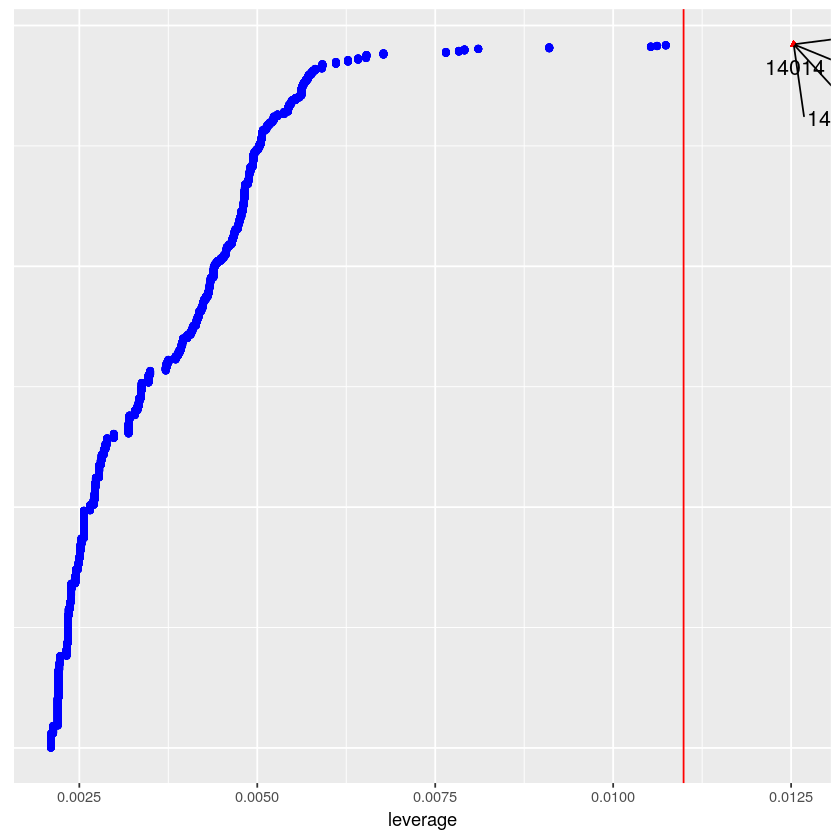

In [107]:
# dotplot_diag(infl$leverage.overall, name = "leverage", cutoff = "internal")
dotplot_diag(infl$leverage.overall, name = "leverage", cutoff = CutOffLeverage)

In [109]:
high_leverage = infl[infl$leverage.overall > CutOffLeverage, ] %>%
  arrange(desc(leverage.overall))

# head(high_leverage, n=10)
high_leverage

id,sentimentScore,sexC,ethnicityC,participantId,cooksd,mdffits,covtrace,covratio,leverage.overall
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14021,-0.3182,-0.5,0.5,49,2.278406e-05,2.277644e-05,0.0003345076,1.000335,0.01253671
14012,-0.4404,-0.5,0.5,49,6.192133e-05,6.190062e-05,0.0003345076,1.000335,0.01253671
14014,-0.4404,-0.5,0.5,49,6.192133e-05,6.190062e-05,0.0003345076,1.000335,0.01253671
14011,-0.5106,-0.5,0.5,49,9.307266e-05,9.304154e-05,0.0003345076,1.000335,0.01253671
14009,-0.4404,-0.5,0.5,49,6.192133e-05,6.190062e-05,0.0003345076,1.000335,0.01253671
14023,-0.4404,-0.5,0.5,49,6.192133e-05,6.190062e-05,0.0003345076,1.000335,0.01253671
14027,-0.5106,-0.5,0.5,49,9.307266e-05,9.304154e-05,0.0003345076,1.000335,0.01253671
14000,-0.5106,-0.5,0.5,49,9.307266e-05,9.304154e-05,0.0003345076,1.000335,0.01253671
14010,-0.4939,-0.5,0.5,49,8.508862e-05,8.506016e-05,0.0003345076,1.000335,0.01253671


In [115]:
# high leverage data points
high_leverage$id

[1] 14021 14012 14014 14011 14009 14023 14027 14000 14010 13982 14003 14007
[13] 14013

### Leverage participants

In [112]:
CutOffLeverageParticipants = mean(infl.classes$leverage.overall)*3
CutOffLeverageParticipants

[1] 0.01309011

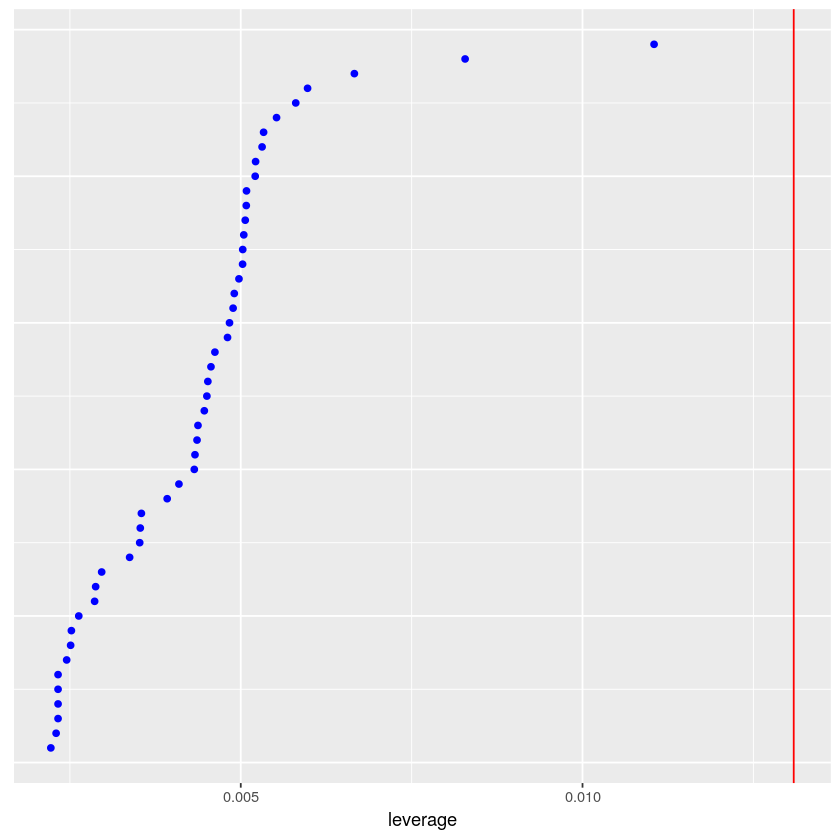

In [113]:
# dotplot_diag(infl.classes$leverage.overall, name = "leverage", cutoff = "internal")
dotplot_diag(infl.classes$leverage.overall, name = "leverage", cutoff = CutOffLeverageParticipants)

In [114]:
high_leverage_participants = infl.classes[infl.classes$leverage.overall > CutOffLeverageParticipants, ] %>%
  arrange(desc(leverage.overall))

# head(high_leverage, n=10)
high_leverage_participants

participantId,cooksd,mdffits,covtrace,covratio,leverage.overall
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [116]:
## No high leverage participants

### Leverage on coefficients

In [119]:
# infl2 <- hlm_influence(m2, level = 1, leverage = c("overall", "fixef", "ranef", "ranef.uc"))

In [120]:
# dotplot_diag(infl2$leverage.fixef, name = "leverage", cutoff = "internal", modify = "dotplot")

In [118]:
# aug <- hlm_augment(m2, level = 1)

In [117]:
# aug2 <- aug %>%
#   arrange(desc(cooksd))

# head(aug2)

## Remove high influence and leverage data points

In [122]:
#add index column to data frame
df$id <- 1:nrow(df)

In [129]:
high_cooksd$id

[1] 12300  5180 14007  1623 11980 12446 14001 13997

In [130]:
high_leverage$id

[1] 14021 14012 14014 14011 14009 14023 14027 14000 14010 13982 14003 14007
[13] 14013

In [131]:
high_cooksd_participants$participantId

[1] 43
49 Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 50

In [134]:
nrow(df)

[1] 14609

In [154]:
`%ni%` <- Negate(`%in%`)
df.filtered <- filter(df, id %ni% high_cooksd$id)
df.filtered <- filter(df.filtered, id %ni% high_leverage$id)
df.filtered <- filter(df.filtered, participantId != 43)

In [155]:
nrow(df.filtered)

[1] 14007

## Refit LMER 

In [156]:
## without derivatives check
control=lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE, optCtrl=list(maxfun=2e6), check.nobs.vs.nRE = "ignore")

m3<-lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), 
    data = df.filtered,
    control=control)

summary(m3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId)
   Data: df.filtered
Control: control

REML criterion at convergence: 11853.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.90304 -0.89100  0.03649  0.70301  2.24674 

Random effects:
 Groups        Name            Variance  Std.Dev. Corr             
 participantId (Intercept)     0.0021458 0.04632                   
               sexC            0.0004474 0.02115  -0.18            
               ethnicityC      0.0001496 0.01223  -0.46 -0.54      
               sexC:ethnicityC 0.0097464 0.09872   0.12  0.25  0.27
 Residual                      0.1349632 0.36737                   
Number of obs: 14007, groups:  participantId, 48

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     -0.093153   0.007510 45.260227 -12.403 3.68e-16 ***
se

In [157]:
## Type III anova table with p-values for F-tests based on Satterthwaite's
## method:
(aov <- anova(m3))

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sexC,1.514137,1.514137,1,53.349037,11.218889,0.001491705
ethnicityC,0.750877,0.750877,1,78.165176,5.563568,0.020836471
sexC:ethnicityC,1.532495,1.532495,1,4.408511,11.354909,0.024153807


## Model interpretation

In [181]:
#### UPDATE #####

## Indiviual subject data points

In [158]:
p = ggplot(df.filtered,aes(sex,sentimentScore,color=ethnicity,group=ethnicity))+
    geom_point()+
    geom_smooth(method="lm",se=F)+
    facet_wrap(~participantId)+
    theme_bw()

In [159]:
pngfile <- fs::path(knitr::fig_path(),  "scaling_2.png")
agg_png(pngfile, width = 60, height = 60, units = "cm", res = 300, scaling = 2.5)
plot(p)
invisible(dev.off())
knitr::include_graphics(pngfile)

`geom_smooth()` using formula 'y ~ x'



[1] "figure/-1/scaling_2.png"
attr(,"class")
[1] "knit_image_paths" "knit_asis"       

![image](figure/-1/scaling_2.png)

## Testing model assumptions & influence/leverage

### Homogeneity of Variance

In [161]:
df.filtered$Model.F.Res<- residuals(m3) #extracts the residuals and places them in a new column in our original data table
df.filtered$Abs.Model.F.Res <-abs(df.filtered$Model.F.Res) #creates a new column with the absolute value of the residuals
df.filtered$Model.F.Res2 <- df.filtered$Abs.Model.F.Res^2 #squares the absolute values of the residuals to provide the more robust estimate
Levene.Model.F <- lm(Model.F.Res2 ~ participantId, data=df.filtered) #ANOVA of the squared residuals
anova(Levene.Model.F) #displays the results

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
participantId,1,0.07224637,0.07224637,3.878487,0.04892831
Residuals,14005,260.87763525,0.01862746,NA,NA


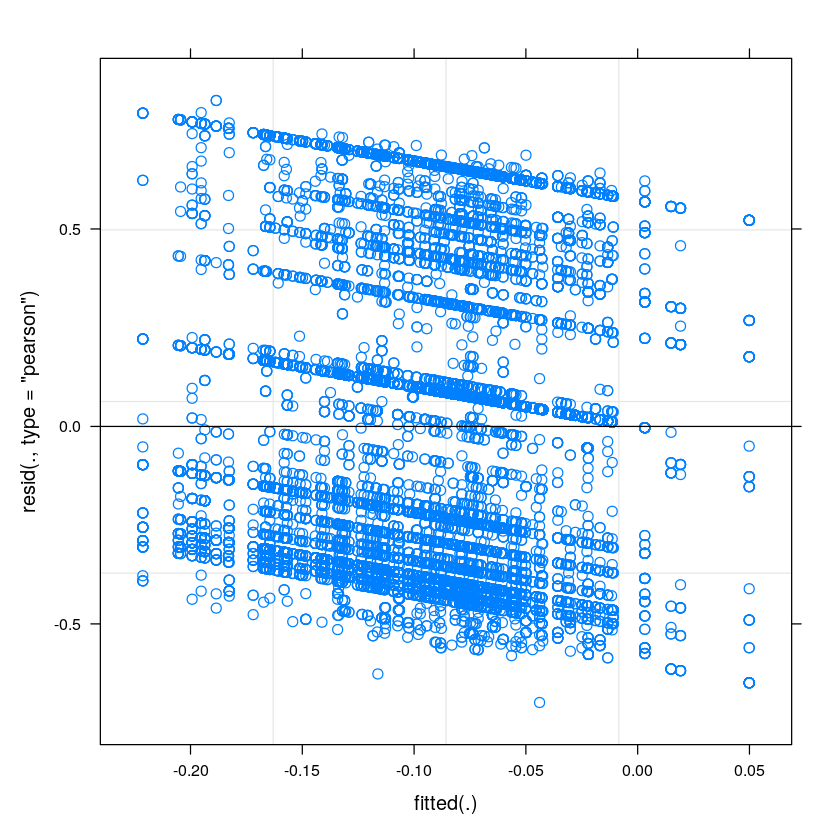

In [163]:
Plot.Model.F <- plot(m3) #creates a fitted vs residual plot
Plot.Model.F

In [164]:
resid1.filtered <- hlm_resid(m3, level = 1, standardize = TRUE)

Warning message in LSresids.lmerMod(object, level = 1, standardize = standardize):
“LS residuals might be inaccurate as one or more groups are rank deficient.
Use the 'include.ls = FALSE' parameter to get EB residuals only.”


In [166]:
head(resid1.filtered)

id,sentimentScore,sexC,ethnicityC,participantId,.std.resid,.fitted,.std.ls.resid,.ls.fitted,.chol.mar.resid,.mar.fitted
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.5106,-0.5,-0.5,0,-1.1891102,-0.07375257,-1.0315839,-0.09638793,-1.1777081,-0.07262901
2,-0.2732,0.5,-0.5,0,-0.3882196,-0.13057845,-0.2400244,-0.17686909,-0.3728524,-0.12899260
3,-0.2732,-0.5,0.5,0,-0.5433628,-0.07358296,-0.6467776,-0.01342333,-0.4716495,-0.09008879
4,0.4404,0.5,0.5,0,1.4453372,-0.09057841,1.2897886,-0.07732679,1.4367005,-0.08090292
5,-0.4404,-0.5,0.5,0,-0.9984856,-0.07358296,-1.0630630,-0.01342333,-0.9240225,-0.09008879
6,-0.4767,0.5,-0.5,0,-0.9421520,-0.13057845,-0.7470783,-0.17686909,-0.9057848,-0.12899260


`geom_smooth()` using formula 'y ~ x'



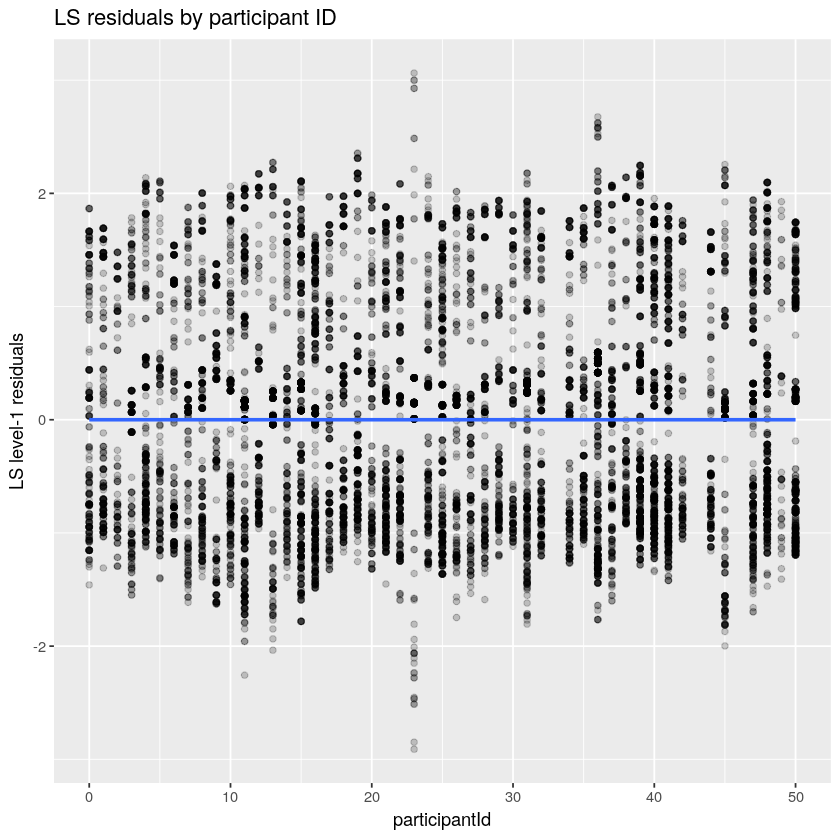

In [167]:
ggplot(data = resid1.filtered, aes(x = participantId, y = .std.ls.resid)) + 
  geom_point(alpha = 0.2) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "LS level-1 residuals", 
       title = "LS residuals by participant ID")

**Level 2 residuals**: participant level

In [170]:
resid2.filtered = hlm_resid(m3, level = "participantId", standardize = TRUE, include.ls = FALSE)

`geom_smooth()` using formula 'y ~ x'



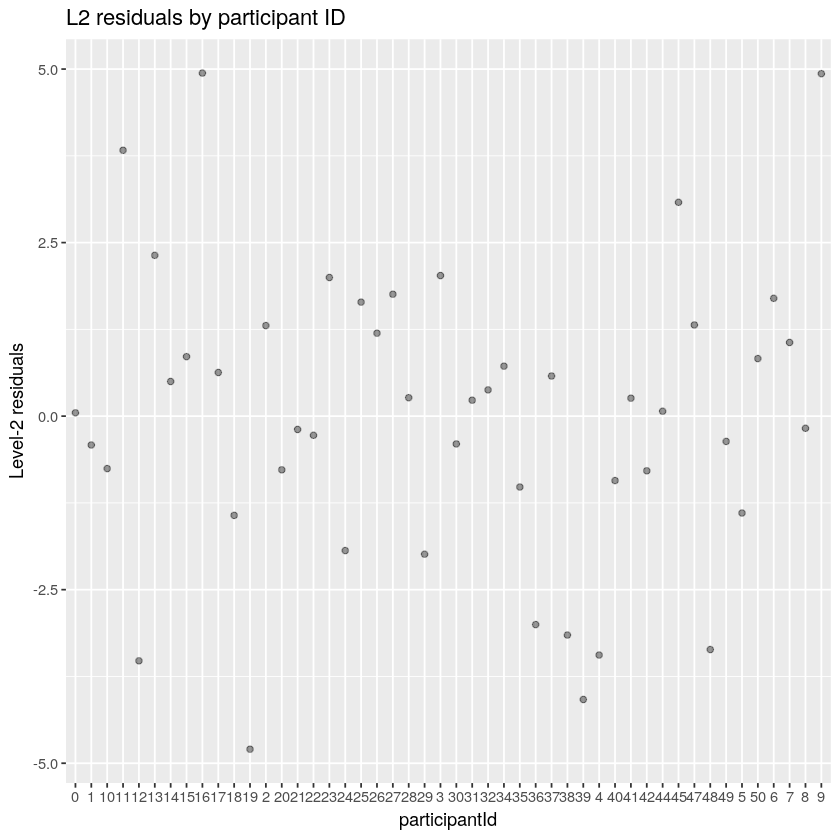

In [171]:
ggplot(data = resid2.filtered, aes(x = participantId, y = .std.ranef.intercept)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

`geom_smooth()` using formula 'y ~ x'



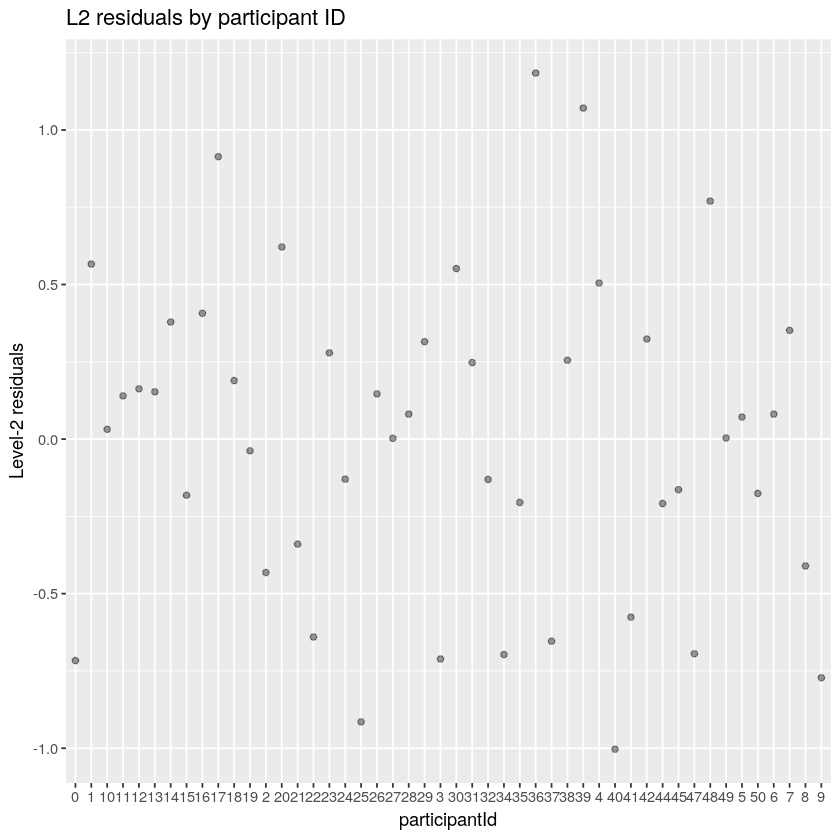

In [178]:
ggplot(data = resid2.filtered, aes(x = participantId, y = .std.ranef.sex_c)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

`geom_smooth()` using formula 'y ~ x'



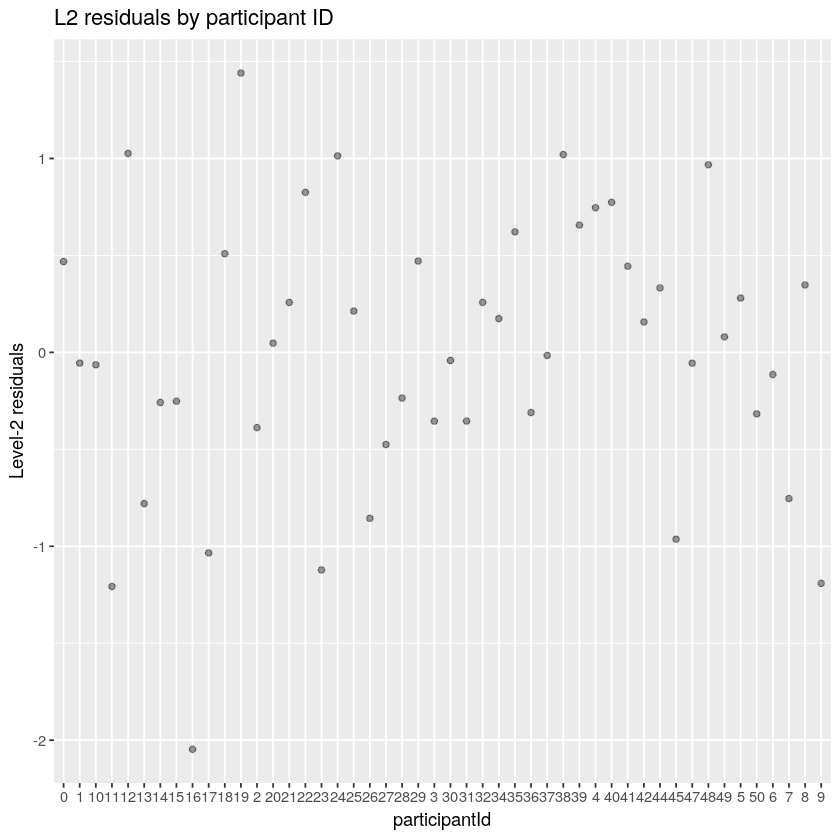

In [179]:
ggplot(data = resid2.filtered, aes(x = participantId, y = .std.ranef.ethnicity_c)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

`geom_smooth()` using formula 'y ~ x'



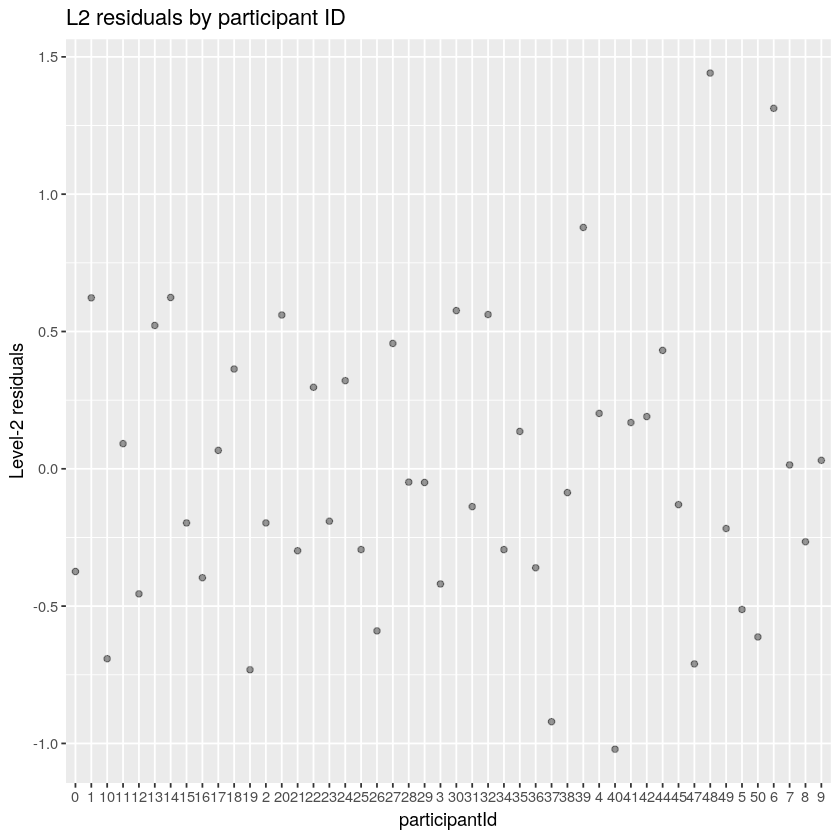

In [180]:
ggplot(data = resid2.filtered, aes(x = participantId, y = .std.ranef.sex_c_ethnicity_c)) + 
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess", se = FALSE) + 
  labs(y = "Level-2 residuals", 
       title = "L2 residuals by participant ID")

### Normality of the error term (the residuals of the model are normally distributed)

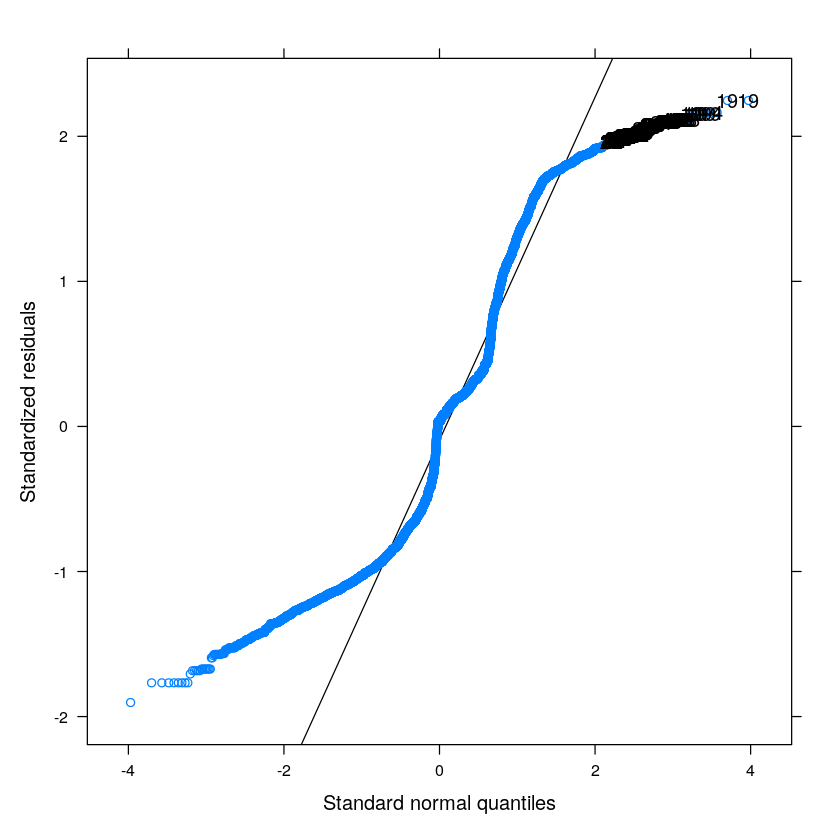

In [168]:
qqmath(m3, id=0.05) #id: identifies values that may be exerting undue influence on the model (i.e. outliers)

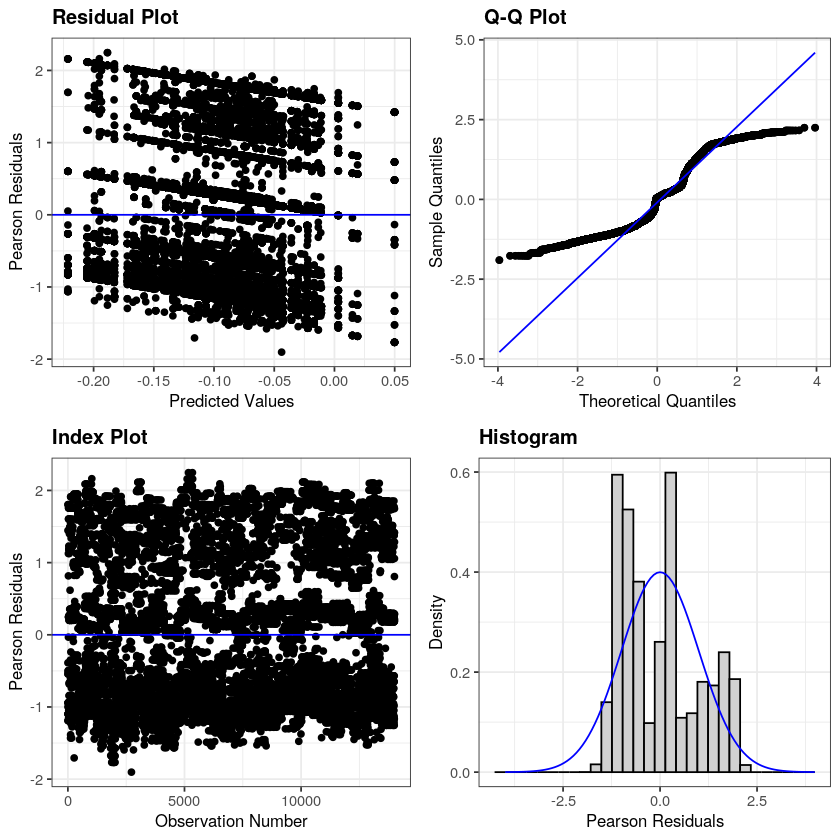

In [169]:
resid_panel(m3)

## Influence

In [ ]:
infl.filtered <- hlm_influence(m3, level = 1)

In [ ]:
CutOff = 4/nrow(infl.filtered)
print(CutOff)

In [ ]:
dotplot_diag(infl.filtered$cooksd, name = "cooks.distance", cutoff = CutOff)